# Линейная регрессия и регуляризация

На сегодняшнем занятии будем работать с датасетом BlackFriday (ниже есть его описание).

Description
The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables.

Classification problem can also be settled in this dataset since several variables are categorical, and some other approaches could be "Predicting the age of the consumer" or even "Predict the category of goods bought". This dataset is also particularly convenient for clustering and maybe find different clusters of consumers within it.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [52]:
data = pd.read_csv('BlackFriday.csv')
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Подготовка данных

In [53]:
missing_values = data.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

Product_Category_3    69.441029
Product_Category_2    31.062713
dtype: float64 %


Скорее всего NaN-ы в Product_Category_2 и Product_Category_3 означают, что человек не покупал продукты из этих категорий.

Поэтому можем заменить эти пропущенные значения на 0.

In [54]:
data = data.fillna(0)

In [55]:
data.shape

(537577, 12)

In [56]:
missing_values = data.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

Series([], dtype: float64) %


Посмотрим, какие типы данных есть в нашем датасете. 

Выведите на экран тип каждой колонки в таблице.

In [57]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

Обработаем нечисловые колонки.

1) Выведите на экран все возможные значения из столбца Gender.

2) Замените значение 'M' на 1, а 'F' на 0.

In [58]:
# data['Gender'].unique()

# или 

#set(data['Gender'])

# или

data['Gender'].value_counts()

M    405380
F    132197
Name: Gender, dtype: int64

In [59]:
data['Gender'] = data['Gender'].map({'M' : 1, 'F' : 0})
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,0,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,0,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,0,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,0,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,1,55+,16,C,4+,0,8,0.0,0.0,7969


Поработаем со столбцом Age.

1) Выведите на экран все возможные значения из столбца Age.

2) Напишите функцию для перевода каждого диапазона возрастов в число (самые маленькие возрасты - 0, следующий диапазон - 1 и т.д.). Замените значения в столбце Age на числовые, применив эту функцию.

In [60]:
set(data['Age'])

{'0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'}

In [61]:
#your code here

def map_age(age):
    if age == '0-17':
        return 0
    elif age == '18-25':
        return 1
    elif age == '26-35':
        return 2
    elif age == '36-45':
        return 3
    elif age == '46-50':
        return 4
    elif age == '51-55':
        return 5
    return 6
    
data['Age'] = data['Age'].apply(map_age)

In [62]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,0,0,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,0,0,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,0,0,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,0,0,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,1,6,16,C,4+,0,8,0.0,0.0,7969


Обработаем столбец City_Category.

1) Выведите все уникальные значения данного столбца.

2) Закодируйте столбец с помощью OneHotEncoding (get_dummies).

In [63]:
set(data.City_Category)

{'A', 'B', 'C'}

In [64]:
data = pd.get_dummies(data, columns=['City_Category'], drop_first=True)

In [65]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_B,City_Category_C
0,1000001,P00069042,0,0,10,2,0,3,0.0,0.0,8370,0,0
1,1000001,P00248942,0,0,10,2,0,1,6.0,14.0,15200,0,0
2,1000001,P00087842,0,0,10,2,0,12,0.0,0.0,1422,0,0
3,1000001,P00085442,0,0,10,2,0,12,14.0,0.0,1057,0,0
4,1000002,P00285442,1,6,16,4+,0,8,0.0,0.0,7969,0,1


Наконец, обработаем Stay_In_Current_City_Years.

1) Выведите на экран все уникальные значения данного столбца.

2) Замените '4+' на 4, а все остальные значения оставьте как есть, но переведите их в числовой вид (x -> int(x)).

In [66]:
set(data.Stay_In_Current_City_Years)

{'0', '1', '2', '3', '4+'}

In [67]:
int('1') + int('1')

2

In [68]:
def map_stay(years):
    if years == '4+':
        return 4
    return int(years)
    
data['Stay_In_Current_City_Years'] = \
    data['Stay_In_Current_City_Years'].apply(map_stay)

In [69]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_B,City_Category_C
0,1000001,P00069042,0,0,10,2,0,3,0.0,0.0,8370,0,0
1,1000001,P00248942,0,0,10,2,0,1,6.0,14.0,15200,0,0
2,1000001,P00087842,0,0,10,2,0,12,0.0,0.0,1422,0,0
3,1000001,P00085442,0,0,10,2,0,12,14.0,0.0,1057,0,0
4,1000002,P00285442,1,6,16,4,0,8,0.0,0.0,7969,0,1


Удалим столбцы User_ID и Product_ID.

In [70]:
data.drop(['User_ID','Product_ID'], axis=1, inplace=True)

In [71]:
data.head()

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_B,City_Category_C
0,0,0,10,2,0,3,0.0,0.0,8370,0,0
1,0,0,10,2,0,1,6.0,14.0,15200,0,0
2,0,0,10,2,0,12,0.0,0.0,1422,0,0
3,0,0,10,2,0,12,14.0,0.0,1057,0,0
4,1,6,16,4,0,8,0.0,0.0,7969,0,1


# Исследование данных

1. Как влияет пол на целевую переменную Purchase? Постройте диаграмму.

2. Как влияет возраст на целевую переменную Purchase? Постройте диаграмму.

3. Как влияет City_Category на целевую переменную Purchase? Постройте диаграмму для каждой закодированной категории.

In [35]:
import seaborn as sns

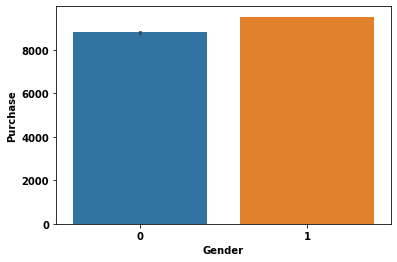

In [38]:
sns.barplot(y='Purchase', x='Gender', data=data)

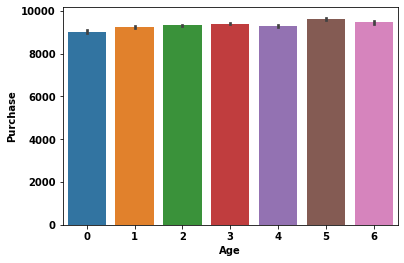

In [39]:
sns.barplot(y='Purchase', x='Age', data=data)

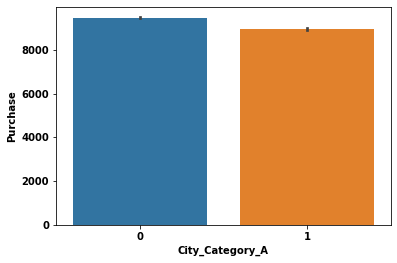

In [40]:
sns.barplot(y='Purchase', x='City_Category_A', data=data)

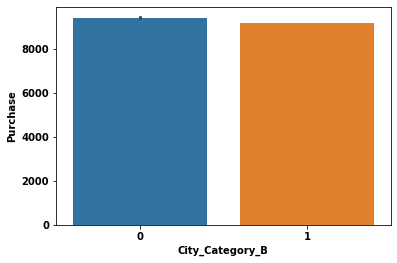

In [41]:
sns.barplot(y='Purchase', x='City_Category_B', data=data)

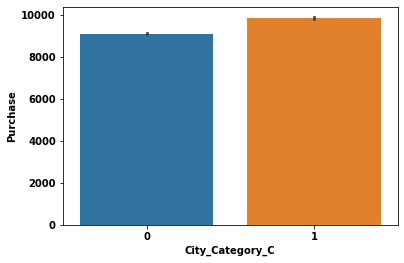

In [44]:
sns.barplot(y='Purchase', x='City_Category_C', data=data)

Нарисуйте матрицу корреляций признаков.

C:\Users\elena\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


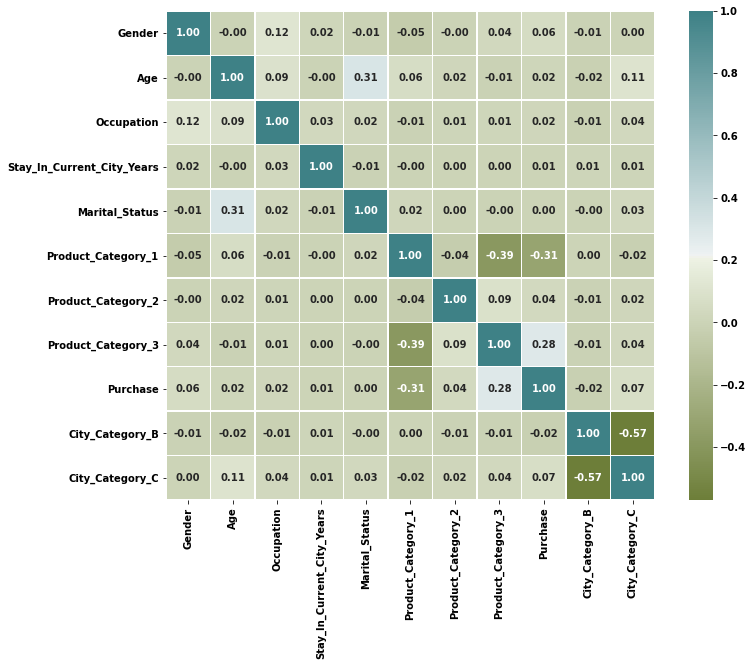

In [72]:
plt.figure(figsize=(12,9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

# Построение модели

In [97]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

y = data['Purchase']
X = data.drop(['Purchase'],axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=111)

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)
print(ypred_train[:10])

[ 6964.68366044  9416.16968144  8856.96577882 13510.04164461
 13307.48879858  7443.01081392 13651.91386892  6696.47805706
  8821.69218084  7150.36017488]


In [98]:
r2_score(ytrain,ypred_train), r2_score(ytest,ypred_test)

(0.291086268827769, 0.29052474259396366)

In [99]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

,0,0
0,Gender,35.821397
1,Age,124.614789
2,Occupation,28.273978
3,Marital_Status,-19.595526
4,Product_Category_1,1260.521365
5,Product_Category_2,16.137825
6,Product_Category_3,638.644187
7,City_Category_B,61.311180
8,City_Category_C,273.420266
9,NEW,3516.702893


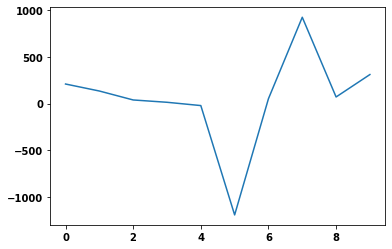

In [76]:
plot(regressor.coef_)

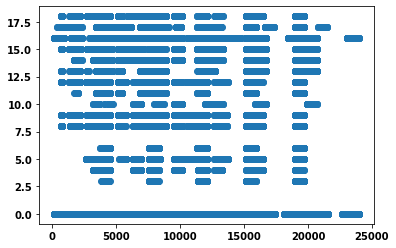

In [81]:
plt.scatter(y, data['Product_Category_3'])

In [83]:
data['NEW'] = 1./data['Product_Category_1']
data['NEW2'] = data['Product_Category_3'] / data['Product_Category_1']

In [87]:
del data['Stay_In_Current_City_Years']

In [96]:
del data['Mean']

Добавим L1 регуляризацию.

In [ ]:
from sklearn.linear_model import Lasso

regressor2 = Lasso(alpha=10)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
print(regressor2.coef_,'\n')

Посмотрим, что происходит при разных значениях параметра регуляризации $\alpha$

In [ ]:
from sklearn.linear_model import Lasso

for a in np.arange(0.1,100.1,25):
    regressor2 = Lasso(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
    print(regressor2.coef_,'\n')

**Видим, что L1-регуляризация зануляет некоторые веса и таким образом производит отбор признаков.**

Подберем оптимальное значение параметра регуляризации по кросс-валидации

In [ ]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

In [ ]:
lasso_cv.coef_

In [ ]:
lasso_cv.alpha_

Обучим модель с найденным параметром регуляризации $\alpha$

In [ ]:
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred2_train), r2_score(ytest,ypred2_test))

Добавим L2 регуляризацию.

In [ ]:
from sklearn.linear_model import Ridge

for a in np.arange(-10,10.1,2.5):
    regressor3 = Ridge(alpha=a)
    regressor3.fit(Xtrain, ytrain)

    ypred3 = regressor3.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:',r2_score(ytest,ypred3), mean_squared_error(ytest,ypred3))
    print(regressor3.coef_)

**Ridge регрессия не зануляет веса (они могут быть очень маленькими, но ненулевыми).**

Теперь подберем оптимальное a по кросс-валидации.

In [ ]:
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

In [ ]:
ridge_cv.alpha_

In [ ]:
regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r3_score(ytrain,ypred3_train), r2_score(ytest,ypred3_test))

Добавим одновременно и L1, и L2 регуляризацию.

У ElasticNet два параметра: alpha и l1_ratio. Используйте ElasticNet со значениями параметров alpha и l1_ratio равными 0.5.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
from sklearn.linear_model import ElasticNet

#your code here

### Посмотрим на веса, которые присвоила линейная регрессия признакам (regressor.coef_).

In [ ]:
#your code here
regressor3.coef_

Можно записать эти веса в таблицу рядом с названиями признаков (для удобства).

In [ ]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor3.coef_))], axis = 1)
coefficients

In [ ]:
len(data),len(Xtest)

# Feature Ingineering

Попробуйте соорудить новые признаки.

Идеи:

1) Группировка исходных признаков по бинам
(попробуйте сгруппировать числовые признаки, например, Product_Category_1(2,3))

2) Перемножение признаков, которые в паре могут влиять на результат (линейная регрессия не умеет умножать)

3) Взятие других функций от признаков.

In [ ]:
#your code here